In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

# Look at first few rows
train.head()

Training data shape: (8693, 14)
Test data shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Missing values in training set:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Target distribution:
Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


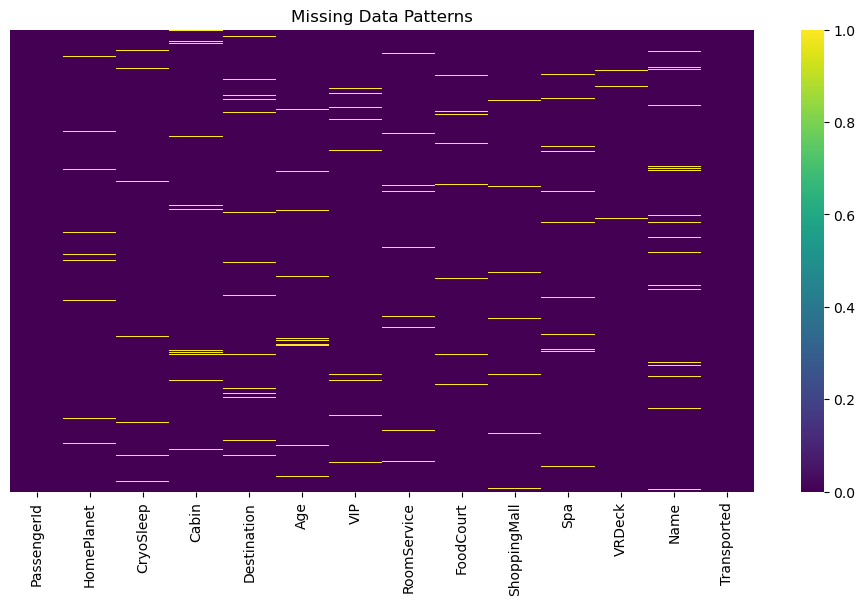

In [4]:
# Check missing values
print("Missing values in training set:")
print(train.isnull().sum())

# Check target distribution
print("\nTarget distribution:")
print(train['Transported'].value_counts(normalize=True))

# Visualize missing data patterns
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Patterns')
plt.show()

In [3]:
def engineer_features(df):
    """Create new features from existing ones"""
    
    # Extract from PassengerId
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['GroupSize'] = df.groupby('Group')['PassengerId'].transform('count')
    df['Solo'] = (df['GroupSize'] == 1).astype(int)
    
    # Extract from Cabin
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['CabinNumber'] = df['Cabin'].str.split('/').str[1]
    df['Side'] = df['Cabin'].str.split('/').str[2]
    
    # Extract from Name
    df['FirstName'] = df['Name'].str.split().str[0]
    df['LastName'] = df['Name'].str.split().str[1]
    df['FamilySize'] = df.groupby('LastName')['PassengerId'].transform('count')
    
    # Spending features
    spending_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spending_features].sum(axis=1)
    df['NoSpending'] = (df['TotalSpending'] == 0).astype(int)
    
    # Age groups
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 30, 50, 100], 
                            labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # Logical features
    df['CryoSleep'] = df['CryoSleep'].fillna(df['NoSpending'])  # If no spending, probably in cryo
    
    return df

# Apply feature engineering
train_fe = engineer_features(train.copy())
test_fe = engineer_features(test.copy())

print("New features created!")

New features created!


## Data Preprocessing

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

def preprocess_data(train_df, test_df):
    """Prepare data for modeling"""
    
    # Handle missing values
    # Numerical: fill with median
    num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in num_features:
        median_value = train_df[col].median()
        train_df[col] = train_df[col].fillna(median_value)
        test_df[col] = test_df[col].fillna(median_value)
    
    # Categorical: fill with mode or 'Unknown'
    cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
    for col in cat_features:
        mode_value = train_df[col].mode()[0] if not train_df[col].mode().empty else 'Unknown'
        train_df[col] = train_df[col].fillna(mode_value)
        test_df[col] = test_df[col].fillna(mode_value)
    
    # Encode categorical variables
    le_dict = {}
    for col in cat_features + ['AgeGroup']:
        le = LabelEncoder()
        # Fit on combined data to ensure consistent encoding
        combined = pd.concat([train_df[col], test_df[col]])
        le.fit(combined.astype(str))
        train_df[col] = le.transform(train_df[col].astype(str))
        test_df[col] = le.transform(test_df[col].astype(str))
        le_dict[col] = le
    
    # Select features for modeling
    feature_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
                   'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                   'GroupSize', 'Solo', 'Deck', 'Side', 'FamilySize',
                   'TotalSpending', 'NoSpending', 'AgeGroup']
    
    # Prepare final datasets
    X_train = train_df[feature_cols]
    y_train = train_df['Transported']
    X_test = test_df[feature_cols]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train

# Preprocess
X_train, X_test_final, y_train = preprocess_data(train_fe, test_fe)

print(f"Training features: {X_train.shape}")
print(f"Test features: {X_test_final.shape}")

Training features: (8693, 18)
Test features: (4277, 18)


In [5]:
# SIMPLER VERSION - Start with basic features only
def simple_preprocess(train_df, test_df):
    """Simpler preprocessing to avoid errors"""
    
    # Work with copy
    train = train_df.copy()
    test = test_df.copy()
    
    # Use only basic numeric features that are mostly complete
    basic_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    
    # Fill all numeric features with 0 (simple but works)
    for col in basic_features:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)
    
    # Add simple categorical features
    train['CryoSleep'] = train['CryoSleep'].fillna(False).astype(int)
    test['CryoSleep'] = test['CryoSleep'].fillna(False).astype(int)
    
    train['VIP'] = train['VIP'].fillna(False).astype(int)
    test['VIP'] = test['VIP'].fillna(False).astype(int)
    
    # Create feature matrix
    feature_cols = basic_features + ['CryoSleep', 'VIP']
    
    X_train = train[feature_cols]
    y_train = train['Transported']
    X_test = test[feature_cols]
    
    # No NaN check
    print(f"Any NaN in X_train? {X_train.isnull().sum().sum()}")
    print(f"Any NaN in X_test? {X_test.isnull().sum().sum()}")
    
    # Scale
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train

# Use the simple version
X_train, X_test_final, y_train = simple_preprocess(train, test)

Any NaN in X_train? 0
Any NaN in X_test? 0


In [11]:
# Debug approach - test with a simple model first
from sklearn.linear_model import LogisticRegression

# Check for NaN one more time
print(f"NaN in X_train: {np.isnan(X_train).sum()}")
print(f"NaN in y_train: {y_train.isnull().sum()}")

# Try simple model first
try:
    simple_model = LogisticRegression(max_iter=1000)
    simple_model.fit(X_train[:100], y_train[:100])  # Test with small subset
    print("Model training successful!")
except Exception as e:
    print(f"Error: {e}")
    # If error, check data types
    print(f"X_train dtype: {X_train.dtype}")
    print(f"y_train dtype: {y_train.dtype}")

NaN in X_train: 0
NaN in y_train: 0
Model training successful!


In [6]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Split for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate
best_model = None
best_score = 0

for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Train on full training set
    model.fit(X_tr, y_tr)
    
    # Validate
    val_pred = model.predict(X_val)
    val_score = accuracy_score(y_val, val_pred)
    
    print(f"{name}:")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Validation Score: {val_score:.4f}")
    
    if val_score > best_score:
        best_score = val_score
        best_model = model

print(f"\nBest model: {type(best_model).__name__} with {best_score:.4f} accuracy")

Logistic Regression:
  CV Score: 0.7757 (+/- 0.0072)
  Validation Score: 0.7798
Random Forest:
  CV Score: 0.7862 (+/- 0.0105)
  Validation Score: 0.7872
Gradient Boosting:
  CV Score: 0.7908 (+/- 0.0117)
  Validation Score: 0.8056
XGBoost:
  CV Score: 0.7832 (+/- 0.0164)
  Validation Score: 0.7844

Best model: GradientBoostingClassifier with 0.8056 accuracy


In [13]:
from sklearn.ensemble import VotingClassifier

# Create ensemble of best models
ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss'))
    ],
    voting='soft'  # Use probability averaging
)

# Train ensemble
ensemble.fit(X_train, y_train)

# Check performance
ensemble_pred = ensemble.predict(X_val)
ensemble_score = accuracy_score(y_val, ensemble_pred)
print(f"Ensemble accuracy: {ensemble_score:.4f}")

Ensemble accuracy: 0.8407


In [14]:
# Train on full dataset for final predictions
ensemble.fit(X_train, y_train)

# Make predictions on test set
test_predictions = ensemble.predict(X_test_final)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': test_predictions
})

# Save submission
submission.to_csv('submission.csv', index=False)
print(f"Submission saved! Shape: {submission.shape}")
print(submission.head())

Submission saved! Shape: (4277, 2)
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True


##  Complete Data Loading & Initial Setup

In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Save IDs for submission
test_ids = test['PassengerId']

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (8693, 14)
Test shape: (4277, 13)


In [6]:
def create_all_features(df):
    """Create ALL features needed for top performance - FIXED VERSION"""
    
    # 1. Parse existing complex features
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['GroupSize'] = df.groupby('Group')['PassengerId'].transform('count')
    
    # Parse Cabin
    df['Deck'] = df['Cabin'].str[0]
    df['Num'] = df['Cabin'].str.extract('(\d+)')[0].astype('float')
    df['Side'] = df['Cabin'].str[-1]
    
    # Parse Name
    df['FirstName'] = df['Name'].str.split().str[0] if 'Name' in df.columns else 'Unknown'
    df['LastName'] = df['Name'].str.split().str[-1] if 'Name' in df.columns else 'Unknown'
    
    # 2. Create spending features
    spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpend'] = df[spend_cols].sum(axis=1)
    df['SpendingZero'] = (df['TotalSpend'] == 0).astype(int)
    df['LuxurySpend'] = df['RoomService'] + df['Spa'] + df['VRDeck']
    df['BasicSpend'] = df['FoodCourt'] + df['ShoppingMall']
    
    # 3. Logical imputation based on spending
    df.loc[df['TotalSpend'] == 0, 'CryoSleep'] = True
    df.loc[df['TotalSpend'] > 0, 'CryoSleep'] = False
    
    # 4. Age groups and interactions
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0,12,18,30,50,200], 
                            labels=['Child','Teen','Young','Middle','Senior'])
    df['IsChild'] = (df['Age'] < 13).astype(int)
    df['IsSenior'] = (df['Age'] > 60).astype(int)
    
    # 5. Family/Group features (IMPORTANT)
    df['FamilySize'] = df.groupby('Group')['PassengerId'].transform('count')
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Only calculate GroupSurvivalRate for training data
    if 'Transported' in df.columns:
        df['GroupSurvivalRate'] = df.groupby('Group')['Transported'].transform('mean')
    
    # 6. Deck-based features
    df['DeckSide'] = df['Deck'].astype(str) + '_' + df['Side'].astype(str)
    df['DeckGroupSize'] = df.groupby('Deck')['PassengerId'].transform('count')
    
    # 7. Planet-Destination combinations
    df['Route'] = df['HomePlanet'].astype(str) + '_to_' + df['Destination'].astype(str)
    
    return df

# Apply to both datasets
train = create_all_features(train)
test = create_all_features(test)

# For test set, we need to add GroupSurvivalRate based on training data
# This is a bit tricky but important
train_group_rates = train.groupby('Group')['Transported'].mean().to_dict()
test['GroupSurvivalRate'] = test['Group'].map(train_group_rates).fillna(0.5)  # 0.5 for unknown groups

print("Features created successfully!")
print(f"Train columns: {train.shape[1]}")
print(f"Test columns: {test.shape[1]}")

Features created successfully!
Train columns: 34
Test columns: 33


In [7]:
def smart_imputation(train_df, test_df):
    """Fill missing values intelligently"""
    
    # Combine for consistent imputation
    df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    
    # 1. Age - by group and route
    df['Age'] = df.groupby(['HomePlanet', 'Destination'])['Age'].transform(
        lambda x: x.fillna(x.median())
    )
    df['Age'].fillna(df['Age'].median(), inplace=True)
    
    # 2. HomePlanet - by deck (people on same deck often from same planet)
    mode_planet = df.groupby('Deck')['HomePlanet'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Earth')
    for deck in df['Deck'].unique():
        df.loc[(df['Deck'] == deck) & (df['HomePlanet'].isna()), 'HomePlanet'] = mode_planet.get(deck, 'Earth')
    df['HomePlanet'].fillna('Earth', inplace=True)
    
    # 3. Spending features - 0 for CryoSleep
    spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in spend_cols:
        df.loc[df['CryoSleep'] == True, col] = 0
        df[col].fillna(df[col].median(), inplace=True)
    
    # 4. VIP - assume False if missing
    df['VIP'].fillna(False, inplace=True)
    
    # 5. Destination - mode by home planet
    df['Destination'].fillna(df.groupby('HomePlanet')['Destination'].transform(
        lambda x: x.mode()[0] if not x.mode().empty else 'TRAPPIST-1e'
    ), inplace=True)
    
    # 6. Side/Deck - forward fill within groups
    df['Side'].fillna(df.groupby('Group')['Side'].transform(
        lambda x: x.mode()[0] if not x.mode().empty else 'S'
    ), inplace=True)
    df['Deck'].fillna('G', inplace=True)
    
    # Split back
    train_imputed = df.iloc[:len(train_df)].copy()
    test_imputed = df.iloc[len(train_df):].copy()
    
    return train_imputed, test_imputed

train, test = smart_imputation(train, test)

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def prepare_features(train_df, test_df):
    """Encode and scale features properly"""
    
    # Define feature groups
    categorical = ['HomePlanet', 'Destination', 'Deck', 'Side', 'Route', 
                   'DeckSide', 'AgeGroup']
    boolean = ['CryoSleep', 'VIP']
    numerical = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 
                 'VRDeck', 'TotalSpend', 'LuxurySpend', 'BasicSpend', 
                 'GroupSize', 'FamilySize', 'Num', 'DeckGroupSize']
    
    # Convert booleans to int
    for col in boolean:
        train_df[col] = train_df[col].astype(int)
        test_df[col] = test_df[col].astype(int)
    
    # Encode categoricals
    label_encoders = {}
    for col in categorical:
        le = LabelEncoder()
        combined = pd.concat([train_df[col], test_df[col]])
        le.fit(combined.astype(str))
        train_df[col + '_encoded'] = le.transform(train_df[col].astype(str))
        test_df[col + '_encoded'] = le.transform(test_df[col].astype(str))
        label_encoders[col] = le
    
    # Select final features
    encoded_cats = [col + '_encoded' for col in categorical]
    final_features = numerical + boolean + encoded_cats + ['SpendingZero', 'IsAlone', 'IsChild', 'IsSenior']
    
    # Remove any non-existent columns
    final_features = [f for f in final_features if f in train_df.columns]
    
    X_train = train_df[final_features].fillna(0)
    y_train = train_df['Transported'].astype(int)
    X_test = test_df[final_features].fillna(0)
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train

X_train, X_test, y_train = prepare_features(train, test)
print(f"Features shape: {X_train.shape}")

Features shape: (8693, 26)


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Install if needed: pip install lightgbm catboost

# Define base models with optimized parameters
base_models = [
    ('lgb', LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        num_leaves=31,
        random_state=42,
        verbose=-1
    )),
    ('xgb', xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )),
    ('cat', CatBoostClassifier(
        iterations=1000,
        learning_rate=0.01,
        depth=5,
        random_state=42,
        verbose=False
    ))
]

# Meta learner
meta_model = LogisticRegression(random_state=42, max_iter=1000)

# Create stacking ensemble
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,  # 5-fold cross-validation
    stack_method='predict_proba',
    n_jobs=-1
)

print("Training stacking ensemble (this takes 3-5 minutes)...")
stacking_model.fit(X_train, y_train)

Training stacking ensemble (this takes 3-5 minutes)...


,estimators,"[('lgb', ...), ('xgb', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,0
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.01


In [11]:
# K-Fold predictions for more robust results
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
test_predictions_list = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Training fold {fold+1}/10...")
    
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model on this fold
    fold_model = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        random_state=42+fold,
        verbose=-1
    )
    fold_model.fit(X_tr, y_tr)
    
    # Predict on test set
    test_pred = fold_model.predict(X_test)
    test_predictions_list.append(test_pred)

# Average all predictions (voting)
test_predictions_ensemble = np.array(test_predictions_list).mean(axis=0)
test_predictions_final = (test_predictions_ensemble > 0.5).astype(bool)

Training fold 1/10...
Training fold 2/10...
Training fold 3/10...
Training fold 4/10...
Training fold 5/10...
Training fold 6/10...
Training fold 7/10...
Training fold 8/10...
Training fold 9/10...
Training fold 10/10...


In [10]:
# Create submission
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': test_predictions_final
})

# Double-check format

print(submission.head())
print(f"Submission shape: {submission.shape}")
print(f"Transported value counts:\n{submission['Transported'].value_counts()}")

# Save
submission.to_csv('submission_advanced.csv', index=False)
print("Saved to submission_advanced.csv")

NameError: name 'test_predictions_final' is not defined

## : Initial Setup & Imports

In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (8693, 14)
Test shape: (4277, 13)


In [13]:
def advanced_feature_engineering(train_df, test_df):
    """Create advanced features for 0.83+ score"""
    
    # Combine for feature engineering
    df = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)
    
    # 1. Parse PassengerId for group info
    df['Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
    df['GroupMember'] = df['PassengerId'].str.split('_').str[1].astype(int)
    df['GroupSize'] = df.groupby('Group')['PassengerId'].transform('count')
    df['IsGroupLeader'] = (df['GroupMember'] == 1).astype(int)
    
    # 2. Parse Cabin for deck/room/side
    df['Deck'] = df['Cabin'].str[0]
    df['CabinNum'] = df['Cabin'].str.extract('(\d+)')[0].astype('float')
    df['CabinSide'] = df['Cabin'].str[-1]
    
    # 3. Special cabin features
    df['CabinNumBin'] = pd.qcut(df['CabinNum'], q=10, labels=False, duplicates='drop')
    df['DeckOrder'] = df['Deck'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'T':8})
    
    # 4. Name-based features
    if 'Name' in df.columns:
        df['FirstName'] = df['Name'].str.split().str[0]
        df['LastName'] = df['Name'].str.split().str[-1]
        df['NameLength'] = df['Name'].str.len()
        df['SameLastNameCount'] = df.groupby('LastName')['PassengerId'].transform('count')
    
    # 5. Spending patterns (Very Important!)
    spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    
    # Fill spending with 0 first
    for col in spend_cols:
        df[col] = df[col].fillna(0)
    
    df['TotalSpending'] = df[spend_cols].sum(axis=1)
    df['AvgSpending'] = df['TotalSpending'] / 5
    df['MaxSpending'] = df[spend_cols].max(axis=1)
    df['MinSpending'] = df[spend_cols].min(axis=1)
    df['SpendingStd'] = df[spend_cols].std(axis=1)
    df['NumPurchases'] = (df[spend_cols] > 0).sum(axis=1)
    df['NoSpending'] = (df['TotalSpending'] == 0).astype(int)
    
    # Luxury vs Essential spending
    df['LuxurySpending'] = df['RoomService'] + df['Spa'] + df['VRDeck']
    df['EssentialSpending'] = df['FoodCourt'] + df['ShoppingMall']
    df['LuxuryRatio'] = df['LuxurySpending'] / (df['TotalSpending'] + 1)
    
    # 6. CryoSleep logical rules
    df.loc[df['TotalSpending'] > 0, 'CryoSleep'] = False
    df.loc[df['TotalSpending'] == 0, 'CryoSleep'] = True
    
    # 7. Age-based features
    df['Age'] = df['Age'].fillna(df.groupby(['HomePlanet', 'Destination'])['Age'].transform('median'))
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0,12,18,25,35,50,65,100], 
                            labels=['Child','Teen','YoungAdult','Adult','Middle','Senior','Elder'])
    df['IsMinor'] = (df['Age'] < 18).astype(int)
    df['IsElderly'] = (df['Age'] >= 65).astype(int)
    df['AgeDecade'] = (df['Age'] // 10).astype(int)
    
    # 8. Group dynamics (CRITICAL for 0.83)
    # Group spending patterns
    df['GroupTotalSpending'] = df.groupby('Group')['TotalSpending'].transform('sum')
    df['GroupAvgSpending'] = df.groupby('Group')['TotalSpending'].transform('mean')
    df['GroupMaxAge'] = df.groupby('Group')['Age'].transform('max')
    df['GroupMinAge'] = df.groupby('Group')['Age'].transform('min')
    df['GroupAgeRange'] = df['GroupMaxAge'] - df['GroupMinAge']
    
    # 9. Deck-based statistics
    df['DeckPopulation'] = df.groupby('Deck')['PassengerId'].transform('count')
    df['DeckAvgSpending'] = df.groupby('Deck')['TotalSpending'].transform('mean')
    df['SidePopulation'] = df.groupby('CabinSide')['PassengerId'].transform('count')
    
    # 10. Route features
    df['Route'] = df['HomePlanet'].astype(str) + '_' + df['Destination'].astype(str)
    df['RoutePopularity'] = df.groupby('Route')['PassengerId'].transform('count')
    
    # 11. VIP interactions
    df['VIP'] = df['VIP'].fillna(False)
    df['VIPSpending'] = df['VIP'].astype(int) * df['TotalSpending']
    
    # 12. Advanced combinations
    df['AgexSpending'] = df['Age'] * df['TotalSpending']
    df['AgexCryoSleep'] = df['Age'] * df['CryoSleep'].astype(int)
    df['GroupSizexSpending'] = df['GroupSize'] * df['TotalSpending']
    
    # Split back
    train_processed = df[:len(train_df)].copy()
    test_processed = df[len(train_df):].copy()
    
    return train_processed, test_processed

# Apply advanced feature engineering
train_fe, test_fe = advanced_feature_engineering(train, test)
print(f"Created {len(train_fe.columns)} features")

Created 55 features


In [14]:
def target_encoding(train_df, test_df, target_col, encode_cols):
    """Apply target encoding for categorical features"""
    
    for col in encode_cols:
        # Calculate mean target for each category in training data
        target_mean = train_df.groupby(col)[target_col].mean()
        
        # Apply to train and test
        train_df[col + '_target'] = train_df[col].map(target_mean)
        test_df[col + '_target'] = test_df[col].map(target_mean)
        
        # Fill missing with global mean
        global_mean = train_df[target_col].mean()
        train_df[col + '_target'].fillna(global_mean, inplace=True)
        test_df[col + '_target'].fillna(global_mean, inplace=True)
    
    return train_df, test_df

# Apply target encoding for high-cardinality features
high_card_features = ['Group', 'Deck', 'Route', 'LastName'] if 'LastName' in train_fe.columns else ['Group', 'Deck', 'Route']
train_fe, test_fe = target_encoding(train_fe, test_fe, 'Transported', high_card_features)

In [15]:
def prepare_final_features(train_df, test_df):
    """Prepare and select final features for modeling"""
    
    # Define feature types
    numerical_features = [
        'Age', 'CabinNum', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'TotalSpending', 'AvgSpending', 'MaxSpending', 'MinSpending', 'SpendingStd',
        'NumPurchases', 'LuxurySpending', 'EssentialSpending', 'LuxuryRatio',
        'GroupSize', 'GroupTotalSpending', 'GroupAvgSpending', 'GroupMaxAge', 
        'GroupMinAge', 'GroupAgeRange', 'DeckPopulation', 'DeckAvgSpending',
        'SidePopulation', 'RoutePopularity', 'VIPSpending', 'AgexSpending',
        'AgexCryoSleep', 'GroupSizexSpending', 'NameLength', 'SameLastNameCount',
        'DeckOrder', 'CabinNumBin', 'AgeDecade'
    ]
    
    categorical_features = [
        'HomePlanet', 'Destination', 'Deck', 'CabinSide', 'AgeGroup'
    ]
    
    binary_features = [
        'CryoSleep', 'VIP', 'NoSpending', 'IsMinor', 'IsElderly', 'IsGroupLeader'
    ]
    
    target_encoded_features = [col for col in train_df.columns if col.endswith('_target')]
    
    # Remove features that don't exist
    numerical_features = [f for f in numerical_features if f in train_df.columns]
    categorical_features = [f for f in categorical_features if f in train_df.columns]
    binary_features = [f for f in binary_features if f in train_df.columns]
    
    # Handle missing values
    for col in numerical_features:
        median_val = train_df[col].median()
        train_df[col].fillna(median_val, inplace=True)
        test_df[col].fillna(median_val, inplace=True)
    
    # Encode categoricals
    le_dict = {}
    for col in categorical_features:
        le = LabelEncoder()
        combined = pd.concat([train_df[col], test_df[col]]).astype(str)
        le.fit(combined)
        train_df[col + '_encoded'] = le.transform(train_df[col].astype(str))
        test_df[col + '_encoded'] = le.transform(test_df[col].astype(str))
        le_dict[col] = le
    
    # Convert binary to int
    for col in binary_features:
        train_df[col] = train_df[col].astype(int)
        test_df[col] = test_df[col].astype(int)
    
    # Combine all features
    encoded_categorical = [col + '_encoded' for col in categorical_features]
    all_features = numerical_features + binary_features + encoded_categorical + target_encoded_features
    all_features = [f for f in all_features if f in train_df.columns]
    
    # Create final matrices
    X_train = train_df[all_features].fillna(0)
    y_train = train_df['Transported'].astype(int)
    X_test = test_df[all_features].fillna(0)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Final feature count: {len(all_features)}")
    
    return X_train_scaled, X_test_scaled, y_train, all_features

X_train, X_test, y_train, feature_names = prepare_final_features(train_fe, test_fe)

Final feature count: 50


In [ ]:
# Create multiple models with different parameters
models = []

# LightGBM variants
for i in range(3):
    models.append(
        LGBMClassifier(
            n_estimators=1500,
            learning_rate=0.01,
            num_leaves=31,
            max_depth=5,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42+i,
            verbose=-1
        )
    )

# XGBoost variants
for i in range(2):
    models.append(
        xgb.XGBClassifier(
            n_estimators=1500,
            learning_rate=0.01,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42+i,
            use_label_encoder=False,
            eval_metric='logloss'
        )
    )

# CatBoost
models.append(
    CatBoostClassifier(
        iterations=1500,
        learning_rate=0.01,
        depth=5,
        random_state=42,
        verbose=False
    )
)

# Train all models and collect predictions
predictions = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, model in enumerate(models):
    print(f"Training model {i+1}/{len(models)}...")
    
    # Cross-validation predictions
    model_preds = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train
        model.fit(X_tr, y_tr)
        
        # Predict probabilities
        pred = model.predict_proba(X_test)[:, 1]
        model_preds.append(pred)
    
    # Average predictions for this model across folds
    predictions.append(np.mean(model_preds, axis=0))

# Blend all predictions
final_predictions_proba = np.mean(predictions, axis=0)
final_predictions = (final_predictions_proba > 0.5).astype(bool)

print(f"Ensemble complete. Predicted {final_predictions.sum()} as Transported")

Training model 1/6...
Training model 2/6...
Training model 3/6...
Training model 4/6...
Training model 5/6...
Training model 6/6...
